##### Copyright 2020 The TensorFlow Authors.

# Load and preprocess images

This tutorial shows how to load and preprocess an image dataset in three ways:

- First, you will use high-level Keras preprocessing utilities (such as `keras.utils.image_dataset_from_directory`) and layers (such as `keras.layers.Rescaling`) to read a directory of images on disk.
- Next, you will write your own input pipeline from scratch [using data](../../guide/data.ipynb).
- Finally, you will download a dataset from the large [catalog](https://www.tensorflow.org/datasets/catalog/overview) available in [TensorFlow Datasets](https://www.tensorflow.org/datasets).

## Setup

In [9]:
import os

# This guide can only be run with the torch backend.
os.environ["KERAS_BACKEND"] = "torch"

import torch
!pip install setuptools --break-system-packages
import keras
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf

print(keras.__version__)
print(tf.__version__)

3.4.1
2.17.0


In [10]:
import tensorflow as tf
tf.test.is_gpu_available() # True/False

# Or only check for gpu's with cuda support
tf.test.is_gpu_available(cuda_only=True) 
# tf.config.list_physical_devices('GPU')[0]

False

In [11]:
import pathlib

data_dir = pathlib.Path("trainingImages2withsplit")

In [12]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


In [13]:
# roses = list(data_dir.glob('uniform/*'))
# PIL.Image.open(str(roses[0]))

In [14]:
# roses = list(data_dir.glob('uniform/*'))
# PIL.Image.open(str(roses[1]))

## Load data using a Keras utility

Let's load these images off disk using the helpful `keras.utils.image_dataset_from_directory` utility.

### Create a dataset

Define some parameters for the loader:

In [15]:
batch_size = 32
img_height = 250
img_width = 250

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [16]:
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

NotFoundError: Could not find directory trainingImages2withsplit

In [65]:
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1300 files belonging to 2 classes.
Using 260 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [66]:
class_names = train_ds.class_names
print(class_names)

['crop', 'weed']


### Visualize the data

Here are the first nine images from the training dataset.

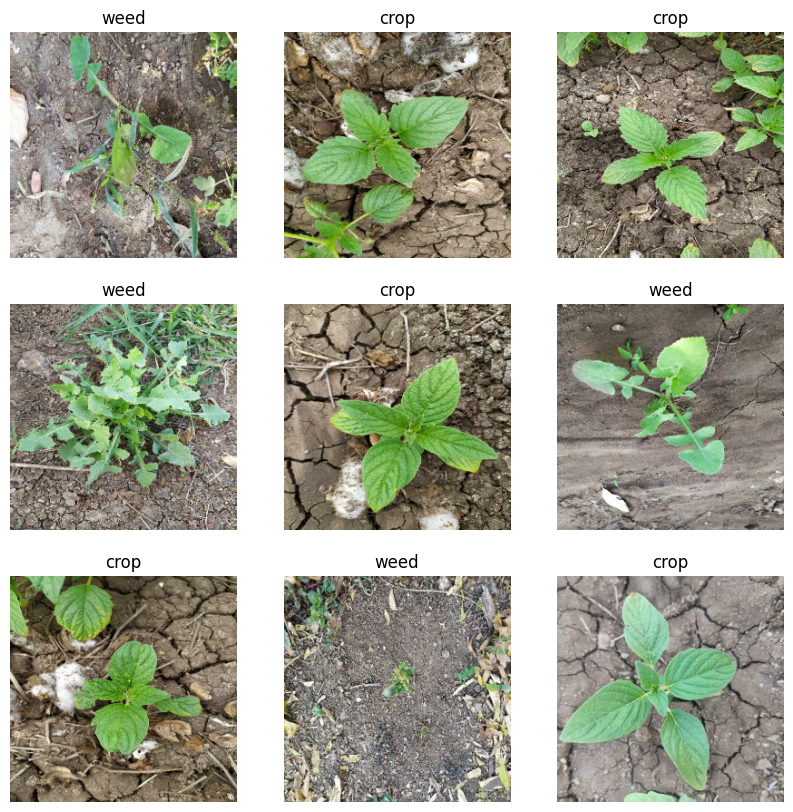

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You can train a model using these datasets by passing them to `model.fit` (shown later in this tutorial). If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [68]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 250, 250, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on either of these tensors to convert them to a `numpy.ndarray`.

### Standardize the data


The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `keras.layers.Rescaling`:

In [69]:
normalization_layer = keras.layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [70]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.97974324


Or, you can include the layer inside your model definition to simplify deployment. You will use the second approach here.

Note: If you would like to scale pixel values to `[-1,1]` you can instead write `keras.layers.Rescaling(1./127.5, offset=-1)`

Note: You previously resized images using the `image_size` argument of `keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `keras.layers.Resizing` layer.

### Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the data API](../../guide/data_performance.ipynb) guide.

In [71]:
# don't run
import tensorflow as tf

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=32)
val_ds = val_ds.cache().prefetch(buffer_size=32)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`keras.layers.Conv2D`) with a max pooling layer (`keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](../images/classification.ipynb) tutorial.

In [72]:
num_classes = len(class_names)

model = keras.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  # keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(num_classes)
])

Choose the `keras.optimizers.Adam` optimizer and `keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [73]:
model.compile(
  optimizer='adam',
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

Note: You will only train for a few epochs so this tutorial runs quickly. 

In [74]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=4
)

Epoch 1/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.5429 - loss: 1.0486 - val_accuracy: 0.6923 - val_loss: 0.5839
Epoch 2/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6451 - loss: 0.6199 - val_accuracy: 0.7654 - val_loss: 0.4654
Epoch 3/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.7631 - loss: 0.4949 - val_accuracy: 0.8423 - val_loss: 0.4572
Epoch 4/4
33/33 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.8602 - loss: 0.4143 - val_accuracy: 0.8615 - val_loss: 0.4051


In [75]:
# model = keras.saving.load_model("2024-03-25-19-39-20.keras")

Note: You can also write a custom training loop instead of using `Model.fit`. To learn more, visit the [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch) tutorial.

In [76]:
model.add(keras.layers.Softmax())  # Add softmax to the original model


In [77]:
predictions = probability_model.predict(val_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step


In [78]:
class_names


['crop', 'weed']

In [79]:
np.argmax(predictions[2])

0

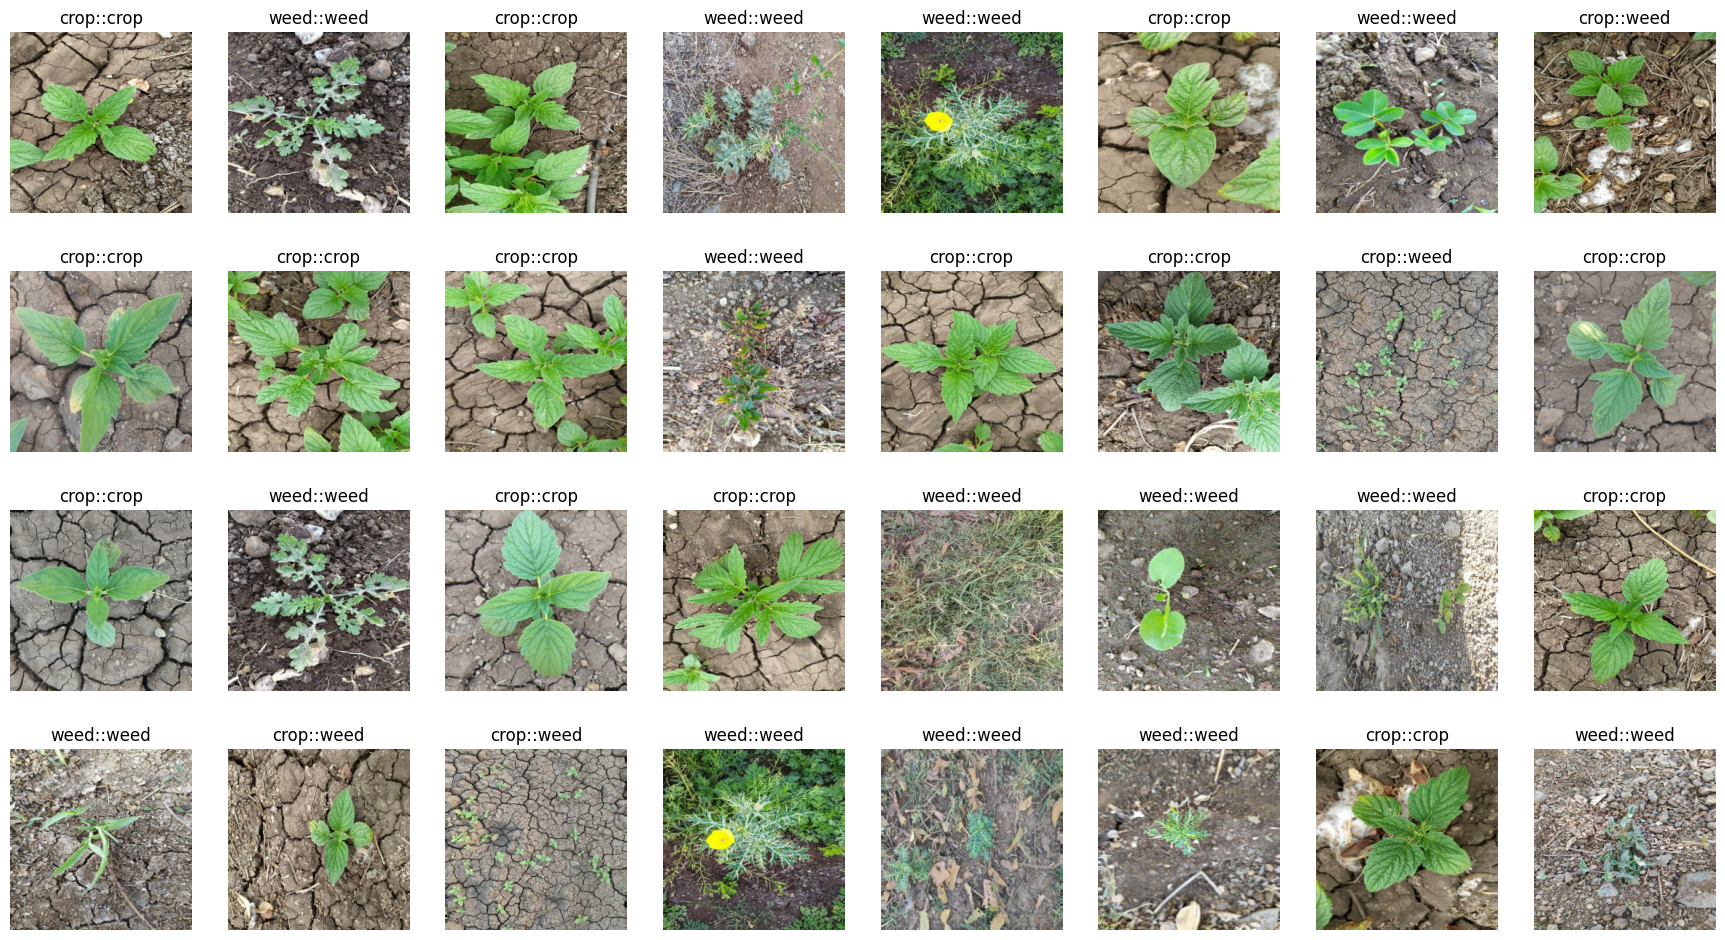

In [80]:
plt.figure(figsize=(22, 15))
for images, labels in val_ds.take(1):
  for i in range(32):
    ax = plt.subplot(5, 8, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]] + "::" + class_names[np.argmax(predictions[i])])
    plt.axis("off")


In [81]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(len(class_names)))
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

In [82]:
predictions[0]

array([0.7805404 , 0.21945962], dtype=float32)

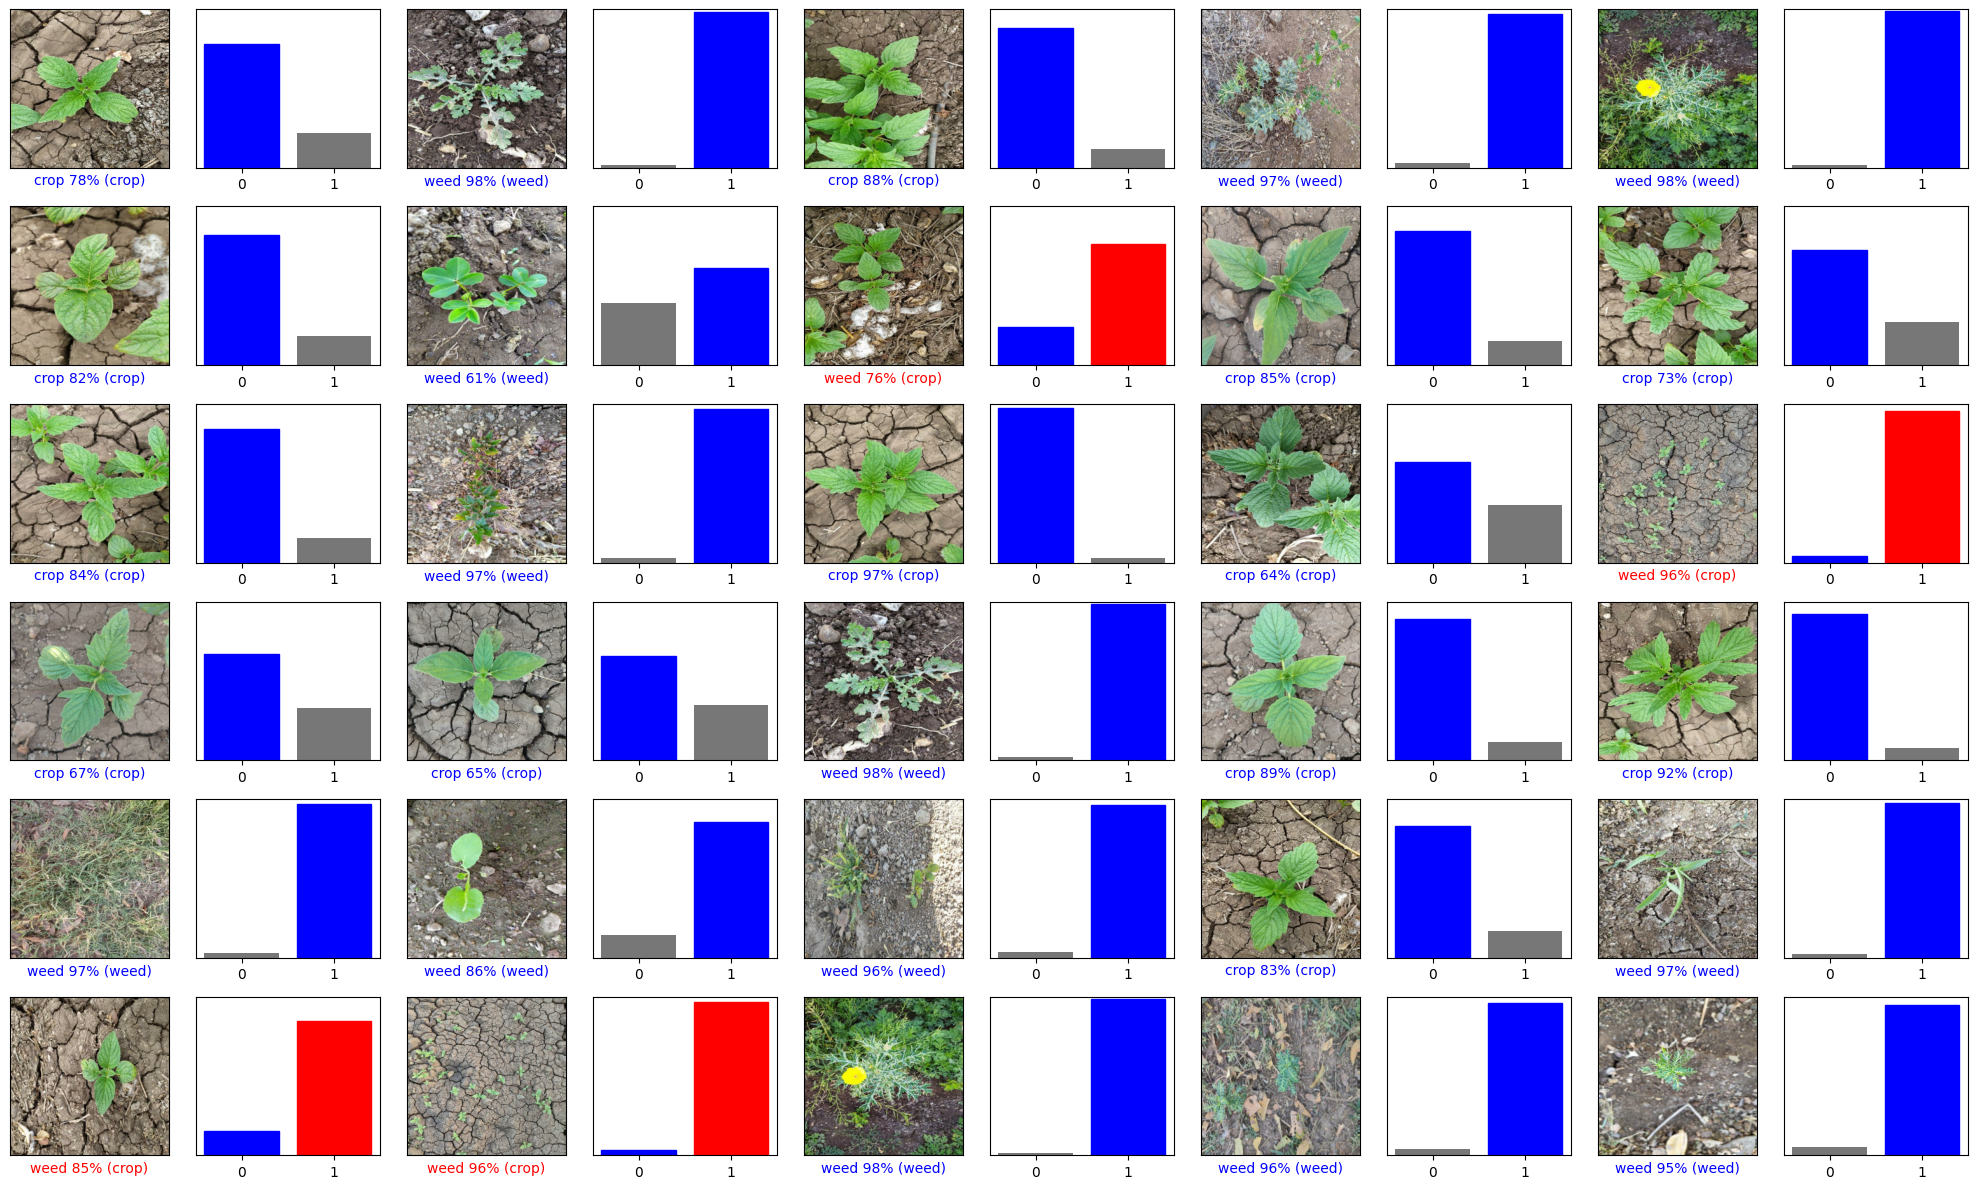

In [83]:
num_rows = 6
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for images, labels in val_ds.take(1):
  for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], labels, images.numpy().astype("uint8"))
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], labels)
  plt.tight_layout()
  plt.show()

In [84]:
import time
model.save("multiselectRemoveHard" + str(time.time())[0:4] + ".keras" )